<h1>
** AGRUPAMIENTO EN IMÁGENES DE GRANOS DE CAFÉ ** 
</h1>

<hr>




<h1>
** Descripción del problema: ** 

Una producción de calidad para el café se asegura cuando los granos seleccionados están en buenas condiciones de maduración, se desea determinar este estado a partir del color, para esto se hace uso de la técnica de aprendizaje no supervisado Kmeans a partir de imágenes.
</h1>

<hr>


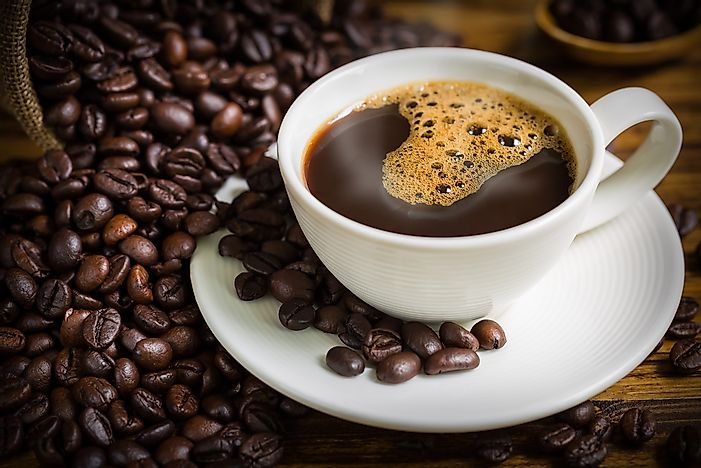

<h1>
0. Importar las imágenes desde Google Drive y las librería necesarias de python
</h1>

<hr>

In [1]:
# montar el Google drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin
from sklearn.utils import shuffle
from time import time

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (12, 5)
plt.style.use('ggplot')


<h1>
1. Cargar imágenes y aplicar el preprocesamiento
</h1>

<hr>

Se muestran las dimensiones de la imagen (ancho, alto, canales):  (1138, 1600, 3)
El canal de color RGB tiene valores entre 0-255 en este caso tenemos mínimo 0 y máximo 255 




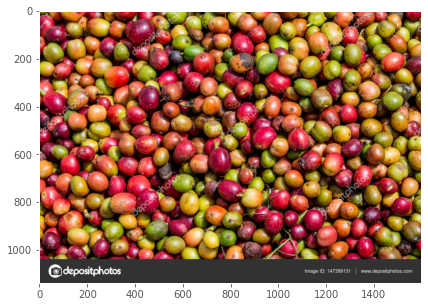

In [3]:
# Cargar las imágenes

original_img = plt.imread(r"Imagen granos de café 1.jpg")

plt.grid(False)
plt.imshow(original_img)


# Comprobar que la imágen esté en canal de colores RGB
print('Se muestran las dimensiones de la imagen (ancho, alto, canales): ', original_img.shape)
print('El canal de color RGB tiene valores entre 0-255 en este caso tenemos mínimo {} y máximo {}'.format(np.min(original_img),np.max(original_img)), '\n\n')


Se normaliza la imagen para obtener valores entre 0 y 1, así es más rápido y preciso el entrenamiento no supervisado.

Dado que la imágen tiene dimensiones (ancho, alto, canales) se debe reducir la imágen a las siguientes dimensiones ( ancho*alto, canales) para poder ingresarla al algoritmo de kmeans

In [4]:
img = np.array(original_img, dtype=np.float64) / 255

w, h, d = original_shape = tuple(img.shape)

assert d == 3
image_array = np.reshape(img, (w * h, d))

print(image_array.shape)

(1820800, 3)


<h1>
2. Encontrar el número de clusters (k) óptimo para este problema
</h1>

<hr>
 
 - **Curva de Elbow:** Este método utiliza los valores de la inercia obtenidos tras aplicar el K-means a diferente número de Clusters (desde 1 a N Clusters), siendo la inercia la suma de las distancias al cuadrado de cada objeto del Cluster a su centroide:

  Una vez obtenidos los valores de la inercia tras aplicar el K-means de 1 a N Clusters, representamos en una gráfica lineal la inercia respecto del número de Clusters. En esta gráfica se debería de apreciar un cambio brusco en la evolución de la inercia, teniendo la línea representada una forma similar a la de un brazo y su codo. El punto en el que se observa ese cambio brusco en la inercia nos dirá el número óptimo de Clusters a seleccionar para ese data set; o dicho de otra manera: el punto que representaría al codo del brazo será el número óptimo de Clusters para ese data set.


<center><img src="https://jarroba.com/wp-content/uploads/2016/05/kmeans_inercia_jarroba.png"> </center>


 - **Estadístico de GAP:**  Corresponde a un método numérico que calcula los valores de kmeans y compara el crecimiento de la pendiente buscando el valor donde este empieza a disminuir, así selecciona el valor de k óptimo.

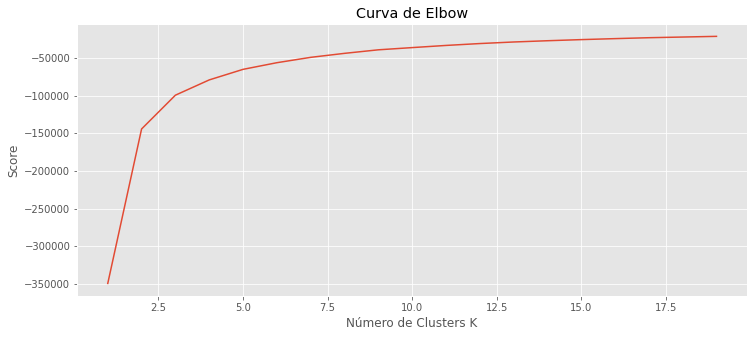


Tiempo de procesamiento curva de Elbow:  2065.621s.


In [5]:
t0 = time() 

Nc = range(1, 20)

kmeans = [KMeans(n_clusters=i) for i in Nc]
kmeans

score = [kmeans[i].fit(image_array).score(image_array) for i in range(len(kmeans))]
score

plt.plot(Nc,score)
plt.xlabel('Número de Clusters K')
plt.ylabel('Score')
plt.title('Curva de Elbow')
plt.show()

print("\nTiempo de procesamiento curva de Elbow:  %0.3fs." % (time() - t0))

Mediante el estadístico de GAP obtenemos el k

In [6]:
t0 = time() 

data = image_array
nrefs = 1
maxClusters = 10

gaps = np.zeros((len(range(1, maxClusters)),))
resultsdf = pd.DataFrame({'clusterCount': [], 'gap': []})
for gap_index, k in enumerate(range(1, maxClusters)):
    refDisps = np.zeros(nrefs) # Holder for reference dispersion results
    # For n references, generate random sample and perform kmeans getting resulting dispersion of each loop
    for i in range(nrefs):
        np.random.seed(0)
        randomReference = np.random.random_sample(size=data.shape) # Create new random reference set
        km = KMeans(k) # Fit to it
        km.fit(randomReference)

        refDisp = km.inertia_
        refDisps[i] = refDisp
        
    km = KMeans(k) # Fit cluster to original data and create dispersion
    km.fit(data)

    origDisp = km.inertia_

    gap = np.log(np.mean(refDisps)) - np.log(origDisp) # Calculate gap statistic
    gaps[gap_index] = gap # Assign this loop's gap statistic to gaps

    resultsdf = resultsdf.append({'clusterCount': k, 'gap': gap}, ignore_index=True)
# Plus 1 because index of 0 means 1 cluster is optimal, index 2 = 3 clusters are optimal
k,resultsdf = (gaps.argmax() + 1, resultsdf)

print('El número de clusters hallado por el estadístico de GAP es: ', k)

print("\nTiempo de procesamiento Estadistico de GAP:  %0.3fs." % (time() - t0))

El número de clusters hallado por el estadístico de GAP es:  5

Tiempo de procesamiento Estadistico de GAP:  689.825s.


<h1>
3. Entrenar el modelo con el número de clusters hallado
</h1>

<hr>

Se considera que para este problema es necesario un valor un poco superior a la k hallada por el estadístico de GAP, con k = 10 se obteniene un buen funcionamiento


In [7]:
k = 10

In [8]:
t0 = time() 

image_array_sample = shuffle(image_array, random_state=0)[:1000]
kmeans = KMeans(n_clusters=k, random_state=0).fit(image_array_sample)

print("Tiempo de clusterizacion mediante Kmeans:  %0.3fs." % (time() - t0))

Tiempo de clusterizacion mediante Kmeans:  0.331s.


Predicción de los colores en la imágen Kmeans

In [9]:
t0 = time()

labels = kmeans.predict(image_array)

print("Tiempo de predicción en Kmeans:  %0.3fs." % (time() - t0))

Tiempo de predicción en Kmeans:  0.312s.


Se eligen k colores aleatorios en la imágen original para comparar la diferencia entre la técnica de clusterización mediante Kmeans y la simple elección de colores sin una técnica específica

In [10]:
codebook_random = shuffle(image_array, random_state=0)[:k]

t0 = time()
labels_random = pairwise_distances_argmin(codebook_random, image_array, axis=0)

print("Tiempo de clusterización con selección aleatoria:  %0.3fs." % (time() - t0))

Tiempo de clusterización con selección aleatoria:  0.305s.


Se debe reconstruir la imágen en el formato RGB para visualizarla

In [11]:
def recreate_image(codebook, labels, w, h):
    """Recreate the (compressed) image from the code book & labels"""
    d = codebook.shape[1]
    image = np.zeros((w, h, d))
    label_idx = 0
    for i in range(w):
        for j in range(h):
            image[i][j] = codebook[labels[label_idx]]
            label_idx += 1
    return image

Visualización de las imágenes


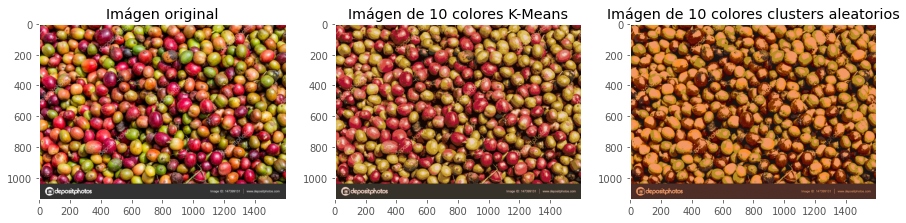

In [12]:
kmeans_img = recreate_image(kmeans.cluster_centers_, labels, w, h)
random_img = recreate_image(codebook_random, labels_random, w, h)


fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(15, 10))


ax1.set_title('Imágen original')
ax1.imshow(original_img)
ax1.grid(False)

ax2.set_title('Imágen de {} clusters K-Means'.format(k))
ax2.imshow(kmeans_img)
ax2.grid(False)

ax3.set_title('Imágen de {} clusters aleatorios'.format(k))
ax3.imshow(random_img)
ax3.grid(False)



<h1>
4. Análisis gráfico de la predicción
</h1>

<hr>

Dado que las imágenes tienen una gran cantidad de pixeles, entonces los gráficos de dispersión se saturan de puntos , así entonces se puede coger una muestra de pixeles (por ejemplo de 1000, 2000 o así ) ingresada por el usuario para sea visualmente más interpretable.

In [14]:
def rgb_to_hex(rgb):
  return '#%02x%02x%02x' % (int(rgb[0]),int(rgb[1]), int(rgb[2]))

# 3D

Cuantos pixeles desea graficar (máximo 1820800): 2000



['#36322a', '#dd8576', '#ab112f', '#eecfc3', '#926924', '#160603', '#64230f', '#dfc166', '#c79b25', '#d95045']


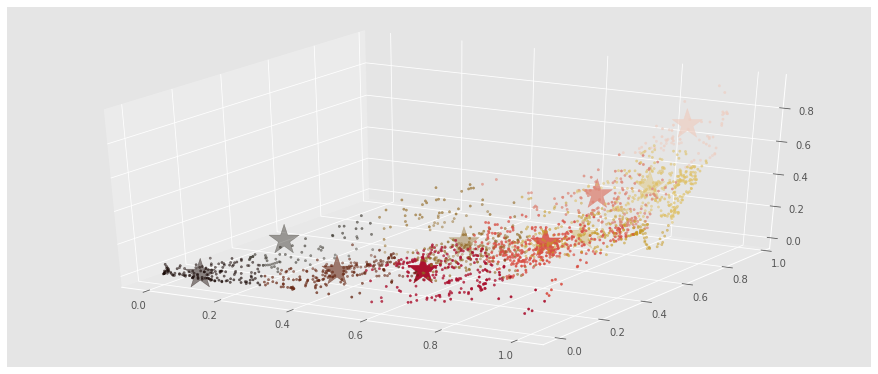

In [16]:
pxls = int(input('Cuantos pixeles desea graficar (máximo {}): '.format(image_array.shape[0])))
print('\n\n')
#pxls = 3000

C = kmeans.cluster_centers_
color=[]
for col in C:
  color.append(rgb_to_hex(col*255))
print(color)

X = image_array[:pxls,:]


lbls = kmeans.predict(X)



asignar=[]
colores = color[:k]
for row in lbls:
    asignar.append(colores[row])



fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(X[:pxls, 0], X[:pxls, 1], X[:pxls, 2], c=asignar, s=5)
ax.scatter(C[:pxls, 0], C[:pxls, 1], C[:pxls, 2], marker='*', c=colores, s=1000)

# 2D


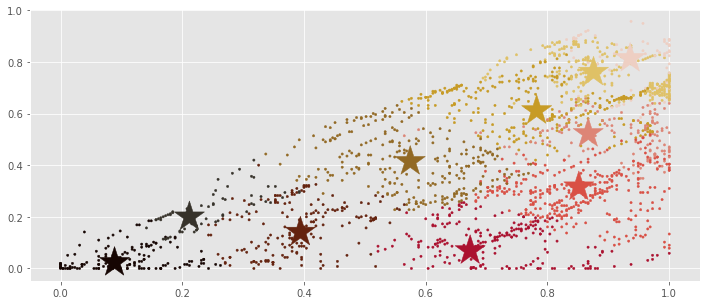

In [17]:
plt.scatter(X[:,0], X[:,1], c=asignar, s=5)
plt.scatter(C[:, 0], C[:, 1], marker='*', c=colores, s=1000)
plt.show()

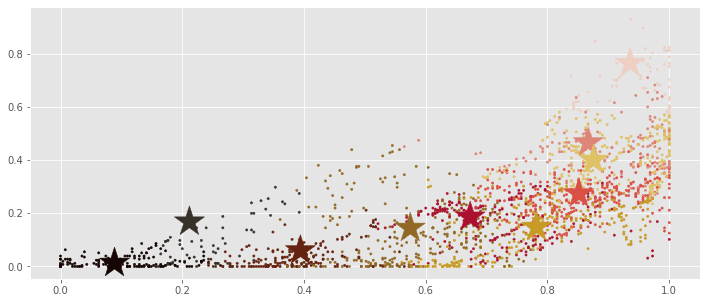

In [18]:
plt.scatter(X[:,0], X[:,2], c=asignar, s=5)
plt.scatter(C[:, 0], C[:, 2], marker='*', c=colores, s=1000)
plt.show()

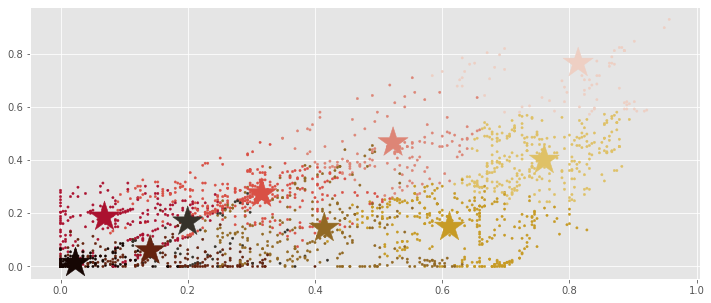

In [19]:
plt.scatter(X[:,1], X[:,2], c=asignar, s=5)
plt.scatter(C[:, 1], C[:, 2], marker='*', c=colores, s=1000)
plt.show()

# Cluster predominante en la imagen 

In [21]:

def predicciones(prediction):

  pred = np.array(prediction, dtype=np.float64) / 255

  w, h, d = original_shape = tuple(pred.shape)

  assert d == 3
  pred_array = np.reshape(pred, (w * h, d))



  new_labels = kmeans.predict(pred_array)

  porcentajes = [];

  for i in range(k):
    porcentajes.append(0)

  pixeles = len(new_labels)

  for cluster in new_labels:
    porcentajes[cluster] += 1

  for i in range(0,len(porcentajes)):
    porcentajes[i] /= pixeles 

  
  return print('La imágen se ubica en el cluster: ', porcentajes.index(max(porcentajes)))



porcentaje_predominante = predicciones(plt.imread(r"Imagen granos de café 1.jpg"))


La imágen se ubica en el cluster:  6


# Realizar predicciones a partir de otras imágenes de granos de café

In [24]:
# Granos verdes

#prediction = predicciones(plt.imread(r"verde.jpg"))
#prediction = predicciones(plt.imread(r"verde_claro.jpg"))

# Granos Maduros
prediction = predicciones(plt.imread(r"negro.jpg"))
#prediction = predicciones(plt.imread(r"rojo.jpg"))



La imágen se ubica en el cluster:  0
